## Lab 8:  Clustering
Environmental justice (EJ) seeks to ensure that all communities, regardless of socioeconomic status or demographic background, have equal access to clean air, water, and, in the form of energy justice, access to renewable energy resources while minimizing exposure to environmental hazards. In this lab, we will apply clustering analysis to explore how U.S. counties group together based on renewable energy potential, demographic characteristics, and environmental risk factors.

The EEIP dataset was collated by the National Renewable Energy Lab (NREL) and contains a large set of features from multiple other databases including SLOPE (renewable energy potential) and EJSCREEN (environmental risk indicators).

Link to metadata: https://ucsb.box.com/s/x3olvh3rd8w5h7xz8jnm3v8g3t4ajjsg

First you will step through a guided clustering exploration of renewable energy production potential.  Then you will formulate a question of your own that brings in an environmental justice component.


### Step 0: Load Libraries and Data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns

# Load the EEIP dataset 
eeip_df = pd.read_csv("/courses/EDS232/Data/eeip.data.csv")

## Part I:
In this part, we will step through an analysis that examines how US counties cluster in their potential production of renewable energy.  

### Step 1: Exploratory Data Analysis

First we need to check for missing data and remove incomplete rows. Since clustering is a distance-based technique, we also need to ensure that the features used for clustering are scaled appropriately to prevent dominant features from skewing results.  For our first analysis, use the following variables from the SLOPE dataset related to energy production potential as your features: 
- `utility_pv_technical_generation_potential_mwh`
- `residential_pv_technical_generation_potential_mwh`
- `land_based_wind_technical_generation_potential_mwh`
- `commercial_pv_technical_generation_potential_mwh`

*Information on these variables is available on line 7 of the ColumnsExplained tab of the metadata*

Once you have removed incomplete rows and scaled, print the shape of your processed dataframe. 

In [2]:
# Select features
eeip_data = eeip_df[['utility_pv_technical_generation_potential_mwh', 
                       'residential_pv_technical_generation_potential_mwh',
                      'land_based_wind_technical_generation_potential_mwh',
                      'commercial_pv_technical_generation_potential_mwh']]

# Remove incomplete rows
eeip_cleaned = eeip_data.dropna()

# Print shape
print("Shape after dropping NaN:", eeip_cleaned.shape)

#Scale the dataframe
scaler = StandardScaler()

eeip_scaled = pd.DataFrame(scaler.fit_transform(eeip_cleaned), columns = eeip_data.columns)

# Print shape
print("Shape after dropping NaN and scaling:", eeip_scaled.shape)

Shape after dropping NaN: (3107, 4)
Shape after dropping NaN and scaling: (3107, 4)


### Step 2: Hierarchical Clustering Analysis

Now that we have preprocessed our dataset and standardized the energy potential features, we will use hierarchical clustering to explore how counties group together based on their energy potential.

A dendrogram is a tree-like visualization that shows how clusters are merged step by step. By analyzing the dendrogram, we can decide the optimal number of clusters by looking at the distance between merges.

Use `linkage()` to perform the clustering.  Use 'ward' for the `method` parameter, a method which minimizes the variance within clusters, producing well-balanced groups. We will first visualize the **full dendrogram** using `dendrogram` before deciding on a truncation strategy.


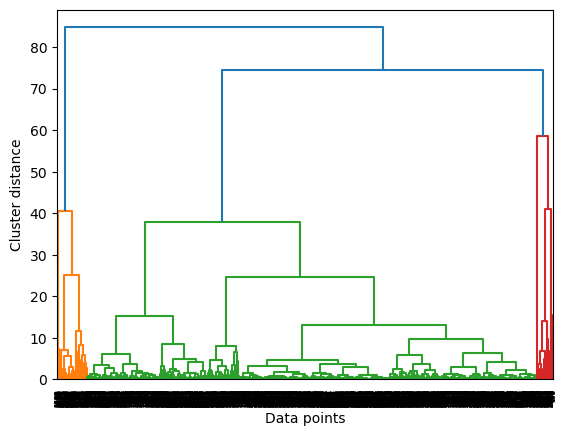

In [76]:
Z = linkage(eeip_scaled, method = 'ward')
dendrogram(Z, show_leaf_counts= False)
plt.ylabel('Cluster distance')
plt.xlabel('Data points')
plt.show()

### Step 3: Set Up Cluster Interpretation

After determining the optimal number of clusters from the dendrogram, we now assign each county to a cluster using the extracted cluster labels.

To better understand the clustering results, we will:
- Define `num_clusters` as the ideal number of clusters based on the dendrogram created above
- Extract cluster assignment attribute from the hierarchical clustering using `fcluster()` with `criterion = "maxclust"`
- Create a new variable `Cluster` in your cleaned dataframe and assign cluster labels to it
- Compute and print the mean values of the original energy potential features for each cluster.

This summary will help us interpret how counties differ in energy potential across clusters and inform possible next steps for analysis.


In [29]:
# Identify ideal number of clusters based on dendrogram
num_cluster = 4

# Extract cluster assignment
Cluster = pd.DataFrame(fcluster(Z, t = 4, criterion = 'maxclust'))

# Create new column Cluster
eeip_scaled['Cluster'] = Cluster

# Compute mean
eeip_cluster_mean = eeip_scaled.groupby('Cluster').mean().reset_index()

eeip_cluster_mean.head()

,Cluster,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh
0,1,2.831068,-0.193351,3.004580,-0.197860
1,2,-0.184742,-0.121549,-0.185776,-0.104943
2,3,-0.076363,3.631745,-0.382148,3.046819
3,4,-0.661236,26.888227,-0.527199,37.606587


In [34]:
df_melted_means = pd.melt(eeip_cluster_mean, id_vars= ['Cluster'], value_vars=['utility_pv_technical_generation_potential_mwh',
                                                         'residential_pv_technical_generation_potential_mwh',
                                                         'land_based_wind_technical_generation_potential_mwh',
                                                         'commercial_pv_technical_generation_potential_mwh'],
                    var_name='indicator', value_name='mean_val')

df_melted_means.head()

,Cluster,indicator,mean_val
0,1,utility_pv_technical_generation_potential_mwh,2.831068
1,2,utility_pv_technical_generation_potential_mwh,-0.184742
2,3,utility_pv_technical_generation_potential_mwh,-0.076363
3,4,utility_pv_technical_generation_potential_mwh,-0.661236
4,1,residential_pv_technical_generation_potential_mwh,-0.193351


### Step 4: Visualizing Energy Potential Across Clusters
Now that we have assigned cluster labels, we want to understand how energy potential differs across clusters. To do this, we will visualize these differences using a grouped bar chart.

Each bar should represent the mean value of an energy potential indicator for a specific cluster. These different patterns of potential is what caused the model to segregate the clusters in the way that it did.

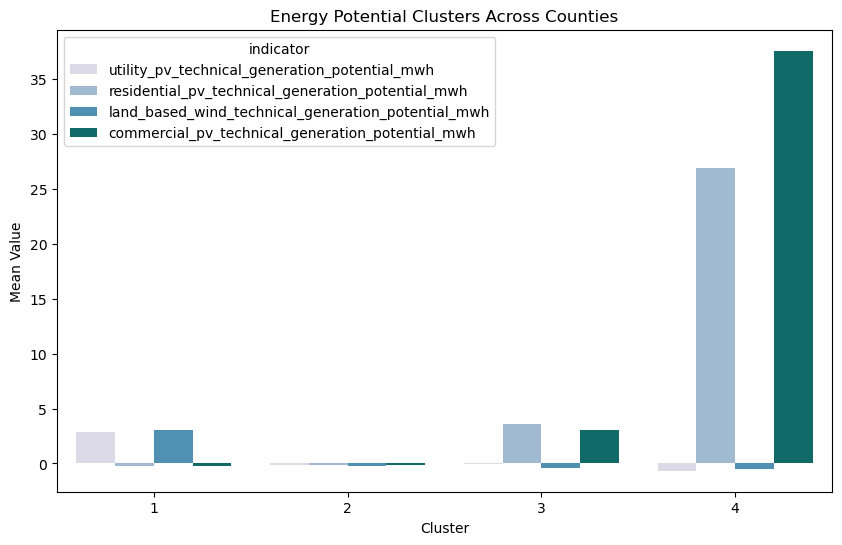

In [40]:
plt.figure(figsize=(10, 6))
# Initialize barplot with the tidy dataset using seaborn
sns.barplot(df_melted_means, 
            x='Cluster',
            y='mean_val',
           hue = 'indicator',
           palette= 'PuBuGn').set(
    xlabel='Cluster', 
    ylabel='Mean Value')

plt.title("Energy Potential Clusters Across Counties")
# Show plot
plt.show()

### Step 5: Interpret Clustering Results
Interpret your plot of the resulting clusters.  How would you characterize and compare the four different clusters in terms of their profile of energy generation?

Each of the four clusters performed differently in terms of their profile of energy generation. The fourth cluster immediately stands out, with high commercial and residential solar generation, while land based wind and utility solar are both negative in terms of mean energy generation. The third cluster shows a similar pattern, with greater commercial and residential solar potential and negative utility solar and land based wind average values. The second cluster looks more uniform in terms of its generation potential across each groups, with land based wind appearing to be slightly more negative than the other indicators. The first cluster stands out with utility solar and land based wind being greater than the other two indicators, commercial and residential solar. Moving from last cluster to the first cluster, it is clear that across clustering there are different patterns. Each cluster can help inform energy development different areas that would be best suitedwith different technologies. 

## Part II: Environmental Justice Metrics
Now it's your turn.

So far, we have clustered counties based on **energy potential**, but energy potential alone does not tell the full story of **energy equity and access**. To deepen the analysis, we need to consider environmental justice (EJ) factors that affect communities’ ability to benefit from renewable energy and the environmental burdens they already experience.

1. Explore EJSCREEN variables:  
   - The EJSCREEN subset of our dataset contains metrics on pollution burden, demographics (population size), and health risks (*lines 31-41 of the ColumnsExplained tab in the metadata sheet linked above*).
   - Identify 1-3 variables that could be important for energy equity analysis.  You could introduce them either as clustering features, as post-clustering variables to help interpret the clusters, or both. 

2. Modify the clustering approach:  
   - Add your selected EJSCREEN variables to our feature set.    
   - Re-run the hierarchical clustering analysis with the expanded dataset (if you added any as clustering features).  

3. Interpret the Results:
   Your interpretation could include considerations such as:
   - How do clusters change when EJSCREEN variables are included?  
   - Are counties with high renewable energy potential also burdened by environmental risks?  
   - What policy recommendations might emerge from these findings?  

In [64]:
# Assign features
energy_equity = eeip_data[['utility_pv_technical_generation_potential_mwh',
                            'residential_pv_technical_generation_potential_mwh',
                           'land_based_wind_technical_generation_potential_mwh',
                           'commercial_pv_technical_generation_potential_mwh', 
                           'lowincome_indicator']]

# Drop NAs from target features
energy_equity = energy_equity.dropna()

# Standardize the features
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(energy_equity)
X2_scaled = pd.DataFrame(X2_scaled, columns=energy_equity.columns)

# Print shape of standardized data frame
print(f"Data frame shape: {X2_scaled.shape}")

Data frame shape: (3107, 5)


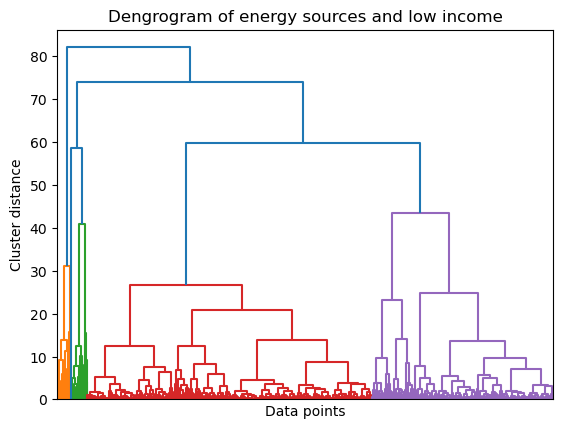

In [65]:
# Perform clustering analysis
cluster2_dend = linkage(X2_scaled, method='ward')

# Plot dendrogram
dendrogram(cluster2_dend, no_labels=True, show_leaf_counts=False)
plt.title('Dengrogram of energy sources and low income')
plt.ylabel('Cluster distance')
plt.xlabel('Data points')
plt.show() 

In [67]:
# Identify the amount of colors (clusters) in dendodram
num_clusters2 = 5 

# Extract cluster assignment
cluster2_extract = fcluster(cluster2_dend, criterion='maxclust', t=num_clusters2)

# Append cluster assignment to data frame 
X2_scaled['cluster'] = cluster2_extract

# Find mean value of energy potential features for each cluster
mean_values2 = X2_scaled.groupby('cluster').mean()

print("Mean values for each feature and cluster:")
mean_values2

Mean values for each feature and cluster:


,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh,lowincome_indicator
cluster,,,,,
1,4.264780,-0.121334,4.248637,-0.174258,0.133245
2,-0.078681,3.596809,-0.382517,3.137359,-0.559785
3,-0.661236,26.888227,-0.527199,37.606587,-0.712090
4,-0.196049,-0.044316,-0.183201,-0.053104,-0.594662
5,-0.022461,-0.248778,-0.015812,-0.201292,0.974009


In [68]:
# Split the new data frame into 2 separate dfs for plotting
income_df = mean_values2[['lowincome_indicator']]

# Average values for power generation
energy_df = mean_values2[['utility_pv_technical_generation_potential_mwh',
'residential_pv_technical_generation_potential_mwh',
'land_based_wind_technical_generation_potential_mwh',
'commercial_pv_technical_generation_potential_mwh']]

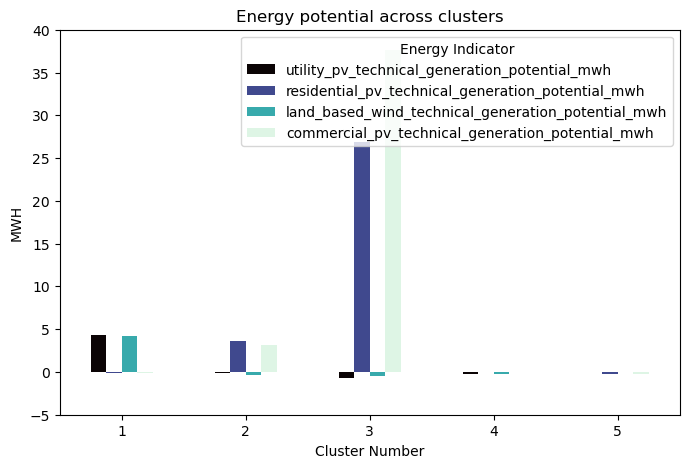

In [70]:
# Plot bar chart using plot()
energy_df.plot(kind="bar", colormap="mako", figsize=(8, 5))

plt.ylim(-5, 40)
plt.xticks(rotation=0)  # Rotate labels by 90 degrees (but 0 worked?)
plt.xlabel("Cluster Number")
plt.ylabel("MWH")
plt.title("Energy potential across clusters")
plt.legend(title="Energy Indicator")

plt.show()

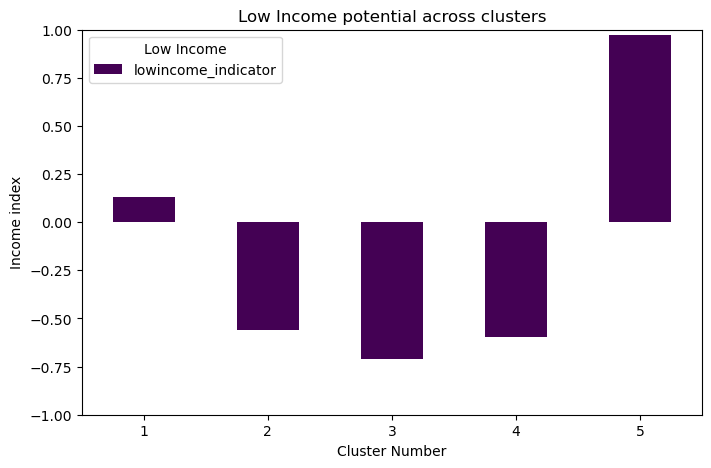

In [75]:
# Plot dodged bar chart
income_df.plot(kind="bar", colormap="viridis", figsize=(8, 5))

plt.ylim(-1, 1)
plt.xticks(rotation=0)  
plt.xlabel("Cluster Number")
plt.ylabel("Income index")
plt.title("Low Income potential across clusters")
plt.legend(title="Low Income")

plt.show()

Which EJSCREEN variable(s) did you add to the analysis? Why did you choose these?  What is the question you are interested in? What did you learn from the analysis

I added low income to this analysis because I was curious to see how income status affects power generation and in turn, energy burden for low income groups. I would have loved to explore the energy burden indicator with low income groups to see how accessible renewable power generation may be across clusters. 